<a href="https://colab.research.google.com/github/liping1005/TextureSynthesis/blob/main/gatys_2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import vgg19
import torch.optim as optim
from PIL import Image

In [3]:
#preload vgg network
new = vgg19(pretrained = True, progress = True)
print(new.features)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPo

In [4]:
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        #get features from pretrained VGG and normalize
        self.transforms = transforms.Compose([transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])])
        model = vgg19(pretrained = True)
        model.requires_grad_(False)
        features = list(model.features)
        self.features = nn.ModuleList(features).eval()

    def forward(self, x):
        #get feature maps for gram matrices
        feature_maps = []
        x = torch.Tensor.float(x)
        x = self.transforms(x)
        for ii, layer in enumerate(self.features):
            x = layer(x)
            if ii in {2, 4, 9, 18, 27, 36}:
              #make each channel into long vector
              #put into one matrix
              F = x.view(x.shape[1], -1)
              feature_maps.append(F)
        return feature_maps

In [5]:
def gatys_loss(ref_gram_list, syn_gram_list):
    assert len(ref_gram_list) == len(syn_gram_list)
    loss = 0
    for n in range(len(ref_gram_list)):
        map_size = 224/2**n * 224/2**n
        const = 1/(4* map_size**2 * ref_gram_list[n].shape[0]**2)
        loss += const * torch.sum(torch.pow(ref_gram_list[n] - syn_gram_list[n],2))
    return loss

In [6]:
def synthesize(model, x , x_hat, optimizer, iterations, lr):
    '''
    DESCRIPTION
    synthesize image using method described in Gatys paper

    INPUTS
    model: neural network used for training
    x: reference image
    x_hat: gaussian white noise that is transformed into image
    optimizer: optimizer used for minimizing loss function
    iterations: number of iterations for backpropogation

    OUTPUT: 
    x_hat: synthesized image
    '''
    x_hat.requires_grad = True

    ref_maps = model(x)
    ref_gram = []
    for m in range(len(ref_maps)):
        map = torch.matmul(ref_maps[m], torch.t(ref_maps[m])).detach()
        ref_gram.append(map)
  
    for k in range(iterations):
        def closure():
            syn_maps = model(x_hat)
            syn_gram = []
            for m in range(len(ref_maps)):
                syn_gram.append(torch.matmul(syn_maps[m], torch.t(syn_maps[m])))
            loss = gatys_loss(ref_gram, syn_gram)
            optimizer.zero_grad()
            loss.backward()
            return loss
        optimizer.step(closure)
        #print(x_hat)
    return x_hat 

In [7]:
syn_image = torch.tensor(np.random.normal(0,0.2, size = (1,3,224,224)))
ref_image_orig = Image.open('/content/drive/MyDrive/pebbles.jpg')
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(), 
                                #transforms.Lambda(lambda x: x[:,:,[2,1,0]]),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])
#store mean and std of original reference image 
avg = []
st_dev = []
for n in range(3):
    avg.append(np.mean(np.asarray(ref_image_orig)[:,:,n]))
    st_dev.append(np.std(np.asarray(ref_image_orig)[:,:,n]))

ref_image = transform(ref_image_orig).reshape((1,3,224,224))
print(ref_image.shape)
print(syn_image)

textureNet = VGG19()
gpu = True
if(gpu == True):
    textureNet.cuda()
LR = 4.5e-2
epochs = 20000
if(gpu == True):
    ref_image = ref_image.cuda()
    syn_image = syn_image.cuda()
optimizer = optim.Adam([syn_image], lr = LR)

y = synthesize(textureNet, ref_image, syn_image, optimizer, epochs, LR)
#y = y[:,:,[2,1,0]]
y = transforms.functional.normalize(y, mean = avg, std = st_dev)
print(y)


torch.Size([1, 3, 224, 224])
tensor([[[[ 0.2223,  0.2690, -0.1557,  ..., -0.0125, -0.1991, -0.3549],
          [-0.1509,  0.0810, -0.0527,  ..., -0.1081,  0.2582,  0.0789],
          [ 0.1695,  0.0538,  0.0053,  ...,  0.3074, -0.0381,  0.3809],
          ...,
          [ 0.0422, -0.0760, -0.0546,  ...,  0.0239, -0.0576,  0.1524],
          [-0.3493, -0.0946,  0.2771,  ..., -0.0186, -0.0253, -0.1042],
          [ 0.2466, -0.0267,  0.4203,  ...,  0.2460,  0.1325,  0.0314]],

         [[ 0.3868, -0.0346,  0.0090,  ...,  0.0593, -0.1981, -0.0420],
          [-0.1870, -0.0616, -0.0728,  ..., -0.2382,  0.1160, -0.0429],
          [-0.0932, -0.2280,  0.1232,  ..., -0.0940, -0.1578,  0.1939],
          ...,
          [-0.0391, -0.1549,  0.2726,  ..., -0.1391, -0.3542, -0.1156],
          [ 0.1270, -0.1864,  0.0063,  ..., -0.1488, -0.3021, -0.1252],
          [ 0.0747, -0.1213,  0.2428,  ...,  0.1810,  0.1784,  0.1677]],

         [[ 0.0429, -0.0430, -0.2413,  ...,  0.1470, -0.2671,  0.1326],
 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[[[-1.8679, -1.8940, -1.8860,  ..., -1.8545, -1.8713, -1.8954],
          [-1.8492, -1.8567, -1.8835,  ..., -1.8579, -1.8903, -1.8741],
          [-1.8692, -1.8684, -1.8805,  ..., -1.8874, -1.8630, -1.8735],
          ...,
          [-1.8505, -1.8313, -1.8627,  ..., -1.8897, -1.9019, -1.8929],
          [-1.8629, -1.8350, -1.8588,  ..., -1.8958, -1.8923, -1.8802],
          [-1.8413, -1.8660, -1.8707,  ..., -1.8950, -1.8845, -1.8846]],

         [[-2.0303, -2.0492, -2.0444,  ..., -2.0278, -2.0425, -2.0397],
          [-2.0233, -2.0379, -2.0464,  ..., -2.0470, -2.0415, -2.0306],
          [-2.0120, -2.0238, -2.0361,  ..., -2.0449, -2.0355, -2.0384],
          ...,
          [-2.0201, -2.0129, -2.0236,  ..., -2.0678, -2.0565, -2.0666],
          [-2.0120, -2.0165, -2.0279,  ..., -2.0653, -2.0672, -2.0672],
          [-2.0208, -2.0194, -2.0212,  ..., -2.0540, -2.0571, -2.0329]],

         [[-2.1601, -2.1810, -2.2027,  ..., -2.1678, -2.1671, -2.2062],
          [-2.1589, -2.1661, -

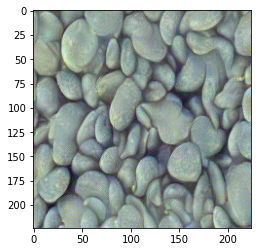

In [8]:
# plt.imshow(y.reshape((3,224,224)).permute(1, 2, 0).detach().cpu())
z = y.reshape((3,224,224)).permute(1,2,0).detach().cpu()
for i in range(3):
    z[:,:,i] = (z[:,:,i] - torch.min(z[:,:,i]))/(torch.max(z[:,:,i]) - torch.min(z[:,:,i]))
plt.imshow(z)

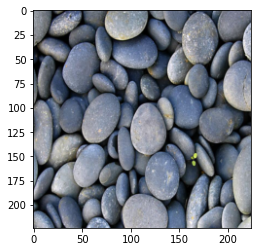

In [9]:
r = ref_image.reshape((3,224,224)).permute(1, 2, 0).detach().cpu()
for i in range(3):
    r[:,:,i] = (r[:,:,i] - torch.min(r[:,:,i]))/(torch.max(r[:,:,i]) - torch.min(r[:,:,i]))
plt.imshow(r)